In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "thedesertm"
os.environ['KAGGLE_KEY'] = "a9cec9328237f6dde657682d25566f21"

## download dataset

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database # api copied from kaggle
! ls

 98% 761M/778M [00:07<00:00, 82.9MB/s]
100% 778M/778M [00:08<00:00, 102MB/s] 
covid19-radiography-database.zip  sample_data


In [ ]:
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
default_epochs = 20

In [ ]:
imagePaths = []
for dirname, _, filenames in os.walk('/content/COVID-19_Radiography_Dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [ ]:
imgSize = 224

X = []
Y = []
hmap = {}
hmap_count = {}
labels = []
lbl_index = 0
normal_counts = 0

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (imgSize, imgSize))
    if label not in hmap:
      hmap[label] = lbl_index
      hmap_count[label] = 0
      lbl_index += 1
    if hmap_count[label] < 3000:
      X.append(image)
      Y.append(hmap[label])
      hmap_count[label] += 1

100%|██████████| 42330/42330 [00:59<00:00, 706.27it/s]


In [ ]:
hmap_count

{'images': 3000, 'masks': 3000}

In [ ]:
hmap

{'images': 1, 'masks': 0}

In [ ]:
X = np.array(X, dtype=np.float16)
Y = np.array(Y, dtype=np.uint8)

In [ ]:
USE_TWO_ONLY = True 
if USE_TWO_ONLY:
  mask_non = Y[hmap[label]!="COVID"]
  mask = Y[hmap[label] =="COVID"]
  Y[mask] = 0
  Y[mask_non] = 1
  hmap = {"COVID":0, "None":1}

In [ ]:
hmap

{'COVID': 0, 'None': 1}

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [ ]:
trainX = np.array(trainX).astype('float16')/255
testX = np.array(testX).astype('float16')/255

In [ ]:
trainX.shape

(4800, 224, 224, 3)

In [ ]:
trainY

array([0, 0, 1, ..., 0, 0, 1], dtype=uint8)

## construct base model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

chx_model = Sequential()
chx_model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
chx_model.add(BatchNormalization())
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
#Normalize the activations of the previous layer at each batch,  applies a transformation that maintains the mean activation close to 0 
#and the activation standard deviation close to 1.
chx_model.add(BatchNormalization())
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
chx_model.add(MaxPooling2D(pool_size=2))
chx_model.add(BatchNormalization())
chx_model.add(Dropout(0.3)) # minimize over fitting 
chx_model.add(Flatten())
# nn layer 
chx_model.add(Dense(500, activation='relu'))
chx_model.add(Dropout(0.4))
chx_model.add(Dense(len(hmap_count), activation='softmax')) # the output is binary classification problem

chx_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                        

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np 
#Early stop to stop training if val loss not change after 10 epocs
es = EarlyStopping(monitor='val_loss',verbose=1, patience=10)
#save best model during training



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
import time 

def compile_train_model(model, name, epochs=1):
  mc =  ModelCheckpoint(filepath=f'best_{name}_model.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True)
  opt =keras.optimizers.Adamax(lr=0.001)
  print(f"starting the training process for {name} model")
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  callback = [mc,es]
  history = model.fit(trainX,trainY, batch_size=64, validation_split=0.1,epochs=epochs,callbacks = callback)
  plt.figure(figsize=(8,6))
  plt.plot(history.history["loss"] , label="training loss")
  plt.plot(history.history["val_loss"] , label="val loss")
  plt.legend()
  plt.title(name)
  st = time.time()
  prediction = model.predict(testX)
  print(f"prediction time {time.time()-st}")
  y_pred = np.argmax(prediction, axis=1)
  cm = confusion_matrix(testY, y_pred)
  cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
  disp = ConfusionMatrixDisplay(confusion_matrix=cmn, display_labels=hmap.keys())
  disp.plot(cmap=plt.cm.Blues)

starting the training process for base model model
Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9889
Epoch 1: val_loss improved from inf to 78.31229, saving model to best_base model_model.hdf5
68/68 [==============================] - 170s 2s/step - loss: 0.1809 - accuracy: 0.9889 - val_loss: 78.3123 - val_accuracy: 0.5042
Epoch 2/20
68/68 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9995
Epoch 2: val_loss did not improve from 78.31229
68/68 [==============================] - 169s 2s/step - loss: 0.0196 - accuracy: 0.9995 - val_loss: 92.3449 - val_accuracy: 0.5042
Epoch 3/20
68/68 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9995
Epoch 3: val_loss improved from 78.31229 to 63.69215, saving model to best_base model_model.hdf5
68/68 [==============================] - 170s 3s/step - loss: 0.0218 - accuracy: 0.9995 - val_loss: 63.6922 - val_accuracy: 0.5042
Epoch 4/20
68/68 [===================

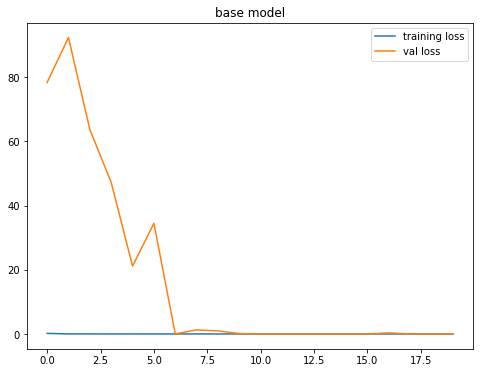

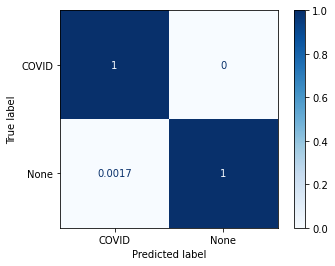

In [ ]:
compile_train_model(chx_model, "base model", default_epochs)

In [ ]:
del chx_model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


starting the training process for vgg 16 model
Epoch 1/5
68/68 [==============================] - ETA: 0s - loss: 0.1619 - accuracy: 0.9630 
Epoch 1: val_loss improved from inf to 0.00450, saving model to best_vgg 16_model.hdf5
68/68 [==============================] - 1200s 18s/step - loss: 0.1619 - accuracy: 0.9630 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 2/5
68/68 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9998 
Epoch 2: val_loss improved from 0.00450 to 0.00111, saving model to best_vgg 16_model.hdf5
68/68 [==============================] - 1197s 18s/step - loss: 0.0042 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/5
68/68 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9998 
Epoch 3: val_loss improved from 0.00111 to 0.00080, saving model to best_vgg 16_model.hdf5
68/68 [==============================] - 1192s 18s/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 8.0306e-04 - val_accuracy: 1.0000
Ep

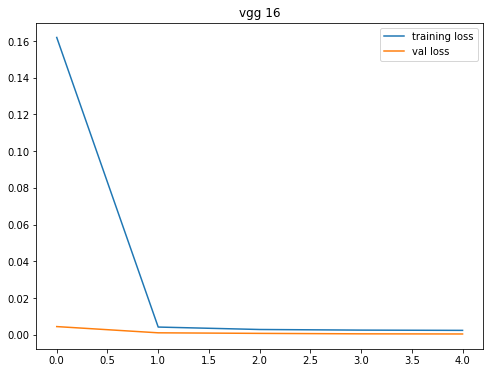

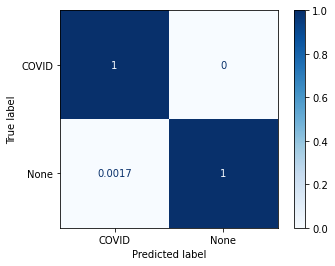

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input
new_input = Input(shape=(imgSize, imgSize, 3))
vgg_model = VGG16(include_top=False,input_tensor=new_input, pooling='avg', classes=len(hmap_count))
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(vgg_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with two categories (covid and none)
predictions = keras.layers.Dense(2, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=vgg_model.input, outputs=predictions)
for layer in vgg_model.layers:
    layer.trainable = False
compile_train_model(full_model, "vgg 16", 5)
vgg_model.summary()

In [ ]:
del vgg_model

In [ ]:
from keras.applications.resnet import ResNet50
from keras.layers import Input
new_input = Input(shape=(imgSize, imgSize, 3))
res_model = ResNet50(include_top=False,input_tensor=new_input, pooling='avg', classes=len(hmap_count))
compile_train_model(res_model, "resnet 50", default_epochs)
res_model.summary()

NameError: ignored

In [ ]:
del res_model

## Alex

In [ ]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(224,224,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(len(hmap_count),activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                      

starting the training process for alex model
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9718
Epoch 1: val_loss improved from inf to 0.03204, saving model to best_alex_model.hdf5
34/34 [==============================] - 141s 3s/step - loss: 0.1718 - accuracy: 0.9718 - val_loss: 0.0320 - val_accuracy: 0.9958
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9972
Epoch 2: val_loss did not improve from 0.03204
34/34 [==============================] - 90s 3s/step - loss: 0.0250 - accuracy: 0.9972 - val_loss: 0.1175 - val_accuracy: 0.9542
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9972
Epoch 3: val_loss did not improve from 0.03204
34/34 [==============================] - 91s 3s/step - loss: 0.0159 - accuracy: 0.9972 - val_loss: 0.8857 - val_accuracy: 0.8125
Epoch 4/20
34/34 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9991
Epoch 4: val

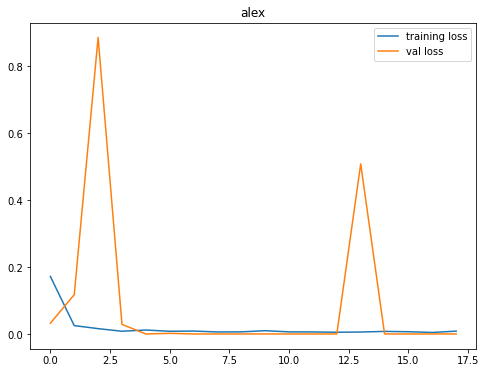

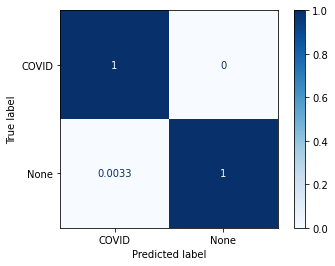

In [ ]:
compile_train_model(model, "alex", default_epochs)